# Data Preparation & Exploration

* https://www.kaggle.com/bertcarremans/data-preparation-exploration
* 캐글 코리아 그랜드 마스터 '이유한'님 참고 필사본 참고

## 키워드
* 지니계수, gini = 2 x AUC - 1, 왜 사용하는가?(숫자적으로 보기 편해서 추측)
* ROC / AUC curve

## 데이터 설명
* Predic if a driver will file an insurance claim next year.
 * 운전자가 내년에 보험 청구를 할 것인지를 예측하는 것
 
* Porto Seguro는 브라질에서 가장 큰 자동차와 주택 보험 회사

* Train / Test = 59만 / 89만

* test 데이터가 훈련 데이터보다 많음
* Null값이 np.NaN이 아닌 -1로 되어 있음
* feature가 무엇을 뜻하는지 제시되어 있지 않음
* feature가 binary인지 categorical인지, ordinal인지 nominal인지만 구분할 수 있음.
* target은 보험 청구를 한다(1), 보험 청구를 하지 않는다(0)로 구성
* 0이 1보다 압도적으로 많음
* 지니계수로 여기서 완벽하게 맞춘다면 0.5
* theoretical maximum for the discrete calculation(이산 계산에 대한 이론적 최대값) = (1 - frac_pos) / 2

## Introduction

이 노트북은 PorteSeguro 대회의 데이터에서 좋은 통찰력을 얻는 것을 목표로 합니다. 그 외에도 모델링을 위해 데이터를 준비하기 위한 몇 가지 팁과 요령을 제공합니다. 노트북은 다음과 같은 주요 섹션으로 구성됩니다.

1. Visual inspection of your data
2. Defining the metadata
3. Descriptive statistics
4. Handling imbalanced classes
5. Data quality checks
6. Exploratory data visualization
7. Feature engineering
8. Feature selection
9. Feature scaling

## Loading packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.preprocessing import Imputer
import statsmodels
from sklearn import impute
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

Version 문제로 인해 기존의 from sklearn.preprocessing import Imputer 는 사용할 수 없었음.

## Loading data

In [2]:
train = pd.read_csv('C:\\Coding\\Kaggle_data\\porto-seguro-safe-driver-prediction\\train.csv')
test = pd.read_csv('C:\\Coding\\Kaggle_data\\porto-seguro-safe-driver-prediction\\test.csv')

## Data at first sight

다음은 대회에 대한 데이터 설명의 일부입니다.

* 유사한 그룹에 속하는 features는 feature name에 태그가 지정됩니다(예: ind, reg, car, calc).
* feature name에는 binary feature를 나타내는 접미사 bin과 categorical feature를 나타내는 cat이 포함됩니다. 
* 이러한 지정이 없는 기능은 연속형(cintinuous) 또는 순서형(ordinal)입니다.
* 값이 -1이면 feature는 관찰에서 누락되었음을 나타냅니다.
* 대상 열(taget columns)은 해당 보험 계약자(policy holder)에 대한 청구가 접수되었는지 여부를 나타냅니다.

시작하는 데 중요한 정보입니다. 이 모든 것을 확인하기 위해 첫 번째 행과 마지막 행을 간단히 살펴보겠습니다.

In [60]:
train['ps_car_12'] 

0         0.368782
1         0.424264
2         0.400000
3         0.400000
4         0.400000
            ...   
216935    0.424264
216936    0.424264
216937    0.400000
216938    0.316228
216939    0.374166
Name: ps_car_12, Length: 216940, dtype: float64

In [3]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [4]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


In [5]:
train

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0


In [6]:
test

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,-1,0,-1,1,1,1,2,1,65,1,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4,1,-1,0,0,11,1,1,0,1,103,1,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11,1,-1,0,-1,14,1,1,2,1,29,3,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,-1.000000,7,1,-1,0,-1,1,1,1,2,1,40,2,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892811,1488022,0,1,6,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0.5,0.3,1.048809,0,1,-1,8,0,14,0,1,0,1,18,2,0.565685,1.528774,0.565685,3.605551,0.3,0.4,0.9,1,1,7,3,10,3,10,4,2,3,4,0,1,0,0,1,0
892812,1488023,5,3,5,1,0,0,0,1,0,0,0,0,0,0,11,1,0,0,0.7,1.0,1.246495,8,1,-1,0,0,10,1,0,0,1,83,2,0.424264,1.040567,0.418569,3.741657,0.3,0.2,0.6,1,3,7,3,10,4,9,6,2,2,11,0,0,1,1,0,0
892813,1488024,0,1,5,0,0,1,0,0,0,0,0,0,0,0,5,0,0,1,0.4,0.0,0.609303,11,1,-1,0,-1,11,1,0,1,1,17,2,0.374166,0.968992,0.390384,3.741657,0.3,0.3,0.9,2,1,10,4,8,2,8,5,2,2,11,0,1,1,0,0,0
892814,1488025,6,1,5,1,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.6,0.6,0.920937,10,0,-1,0,1,10,1,1,0,1,28,3,0.387298,0.725125,0.378153,2.645751,0.1,0.1,0.3,1,1,9,2,10,1,8,1,1,2,7,1,1,0,0,0,0


* 이진 변수(binary variables)
 
* 범주 값이 정수인 범주형 변수(the category values are integers)
 
* 정수(int) 또는 부동 소수점(float) 값이 있는 기타 변수(other variables)
 
* 결측값을 나타내는 -1이 있는 변수(missing values)
 
* 대상 변수(the target variable)와 ID 변수(ID variable)

먼저 train data의 shape 확인

In [7]:
train.shape

(595212, 59)

train data의 중복값 확인

In [8]:
train.drop_duplicates()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0


중복값이 없음을 확인.

test data의 shape을 확인

In [9]:
test.shape

(892816, 58)

테스트 세트에서 하나의 변수가 누락되었지만 이것이 대상 변수(target variable)입니다. 괜찮습니다.
이제 각 유형의 변수가 몇 개인지 조사해 보겠습니다.

따라서 나중에 14개의 범주형 변수에 대한 더미 변수(dummy variables)를 만들 수 있습니다. 

bin 변수는 이미 바이너리이며 더미화가 필요하지 않습니다.

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

info() 메소드를 사용하여 데이터 유형이 정수 또는 부동 소수점임을 알 수 있습니다. 

데이터 세트에 null 값이 없습니다. 

누락된 값이 -1로 대체되기 때문에 이는 정상입니다.

## Metadata

metadata란
* 데이터에 관한 구조화된 데이터
* 다른 데이터를 설명해주는 데이터
* 대량의 정보 가운데 찾고 있는 정보를 효율적으로 찾아내서 이용하기 위해 일정한 규칙에 따라 콘텐츠에 대하여 부여되는 데이터
* 구조화된 정보를 분석, 분류하고 부가적 정보를 추가하기 위해 사용
* 속성 정보
* 데이터를 빨리 찾기 위함

데이터 관리를 용이하게 하기 위해 변수에 대한 메타 정보를 DataFrame에 저장합니다. 이는 분석, 시각화, 모델링 등을 위해 특정 변수를 선택하려는 경우에 유용합니다.

구체적으로 다음을 저장합니다.

* __role__: input, ID, target
* __level__: nominal, interval, ordinal, binary
* __keep__: True or False
* __dtype__: int, float, str

In [11]:
data = []
for f in train.columns:
    # Defining the role
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
        
    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == 'float64': # train[f].dtype == float에서 변경
        level = 'interval'
    elif train[f].dtype == 'int64':   # train[f].dtype == int에서 변경
        level = 'ordinal'
        
    # id를 제외한 모든 변수에 대해 keep을 True로 초기화합니다.
    keep = True
    if f == 'id':
        keep = False
        
    # Defining the data type
    dtype = train[f].dtype
    
    # 변수에 대한 모든 메타데이터를 포함하는 사전 만들기
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype':dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [12]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


삭제되지 않은 모든 명목 변수(nominal variables)를 추출하는 예

& : 비트 연산자로 AND를 뜻하며 둘 다 "참(True)"일 때 True를 반환

* [파이썬 헤엄치기 : 비트 연산자 참고](https://wikidocs.net/95998)

In [13]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

role 및 level의 the number of variables가 아래에 표시됩니다.

- groupby.size() : 집단별 크기
- groupby.sum()
- grouupby.mean()

In [14]:
pd.DataFrame({'count': meta.groupby(['role', 'level'])['role'].size()}).reset_index() 

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


## Descriptive statistics

데이터 프레임에 describe 메서드를 적용할 수도 있습니다. 그러나 범주형 변수와 id 변수에 대해 평균, std, ...를 계산하는 것은 의미가 없습니다. 범주형 변수는 나중에 시각적으로 살펴보겠습니다.

메타 파일 덕분에 기술 통계를 계산할 변수를 쉽게 선택할 수 있습니다. 명확하게 하기 위해 데이터 유형별로 이 작업을 수행합니다.

### Interval variables

척도를 따라 측정된 값을 정의하는 데 사용되는 측정 변수

수치 변수(numerical variables) 중 하나이며 서수 변수의 확장(extension of the ordinal variable.)

* [명목, 서수, 간격 및 비율 변수에 대한 설명](https://www.formpl.us/blog/nominal-ordinal-interval-ratio-variable-example)

In [15]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


#### reg variables
* ps_reg_03에만 누락된 값이 있습니다.
* 범위(최소에서 최대)는 변수 간에 다릅니다. 스케일링(예: StandardScaler)을 적용할 수 있지만 사용하려는 분류기에 따라 다릅니다.

#### car variables
* ps_car_12 및 ps_car_15에 누락된 값이 있습니다 
* 다시, 범위가 다르며 스케일링을 적용할 수 있습니다.

#### calc variables
* 누락된 값 없음
* 이것은 최대값이 0.9이기 때문에 일종의 비율인 것 같습니다.
* 세 가지 _calc 변수 모두 매우 유사한 분포를 가집니다.

전반적으로 구간 변수의 범위가 다소 작은 것을 알 수 있습니다. 

데이터를 익명화(anonymize)하기 위해 일부 변환(예: log)을 한 것은 아닐까요?

### Ordinal variables

In [16]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


* 하나의 누락된 변수(결측치): ps_car_11

* 다양한 범위를 처리하기 위해 스케일링을 적용할 수 있습니다.

### Binary variables

In [17]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


train data의 선험적 값(priori)은 3.645%로 심하게 불균형합니다.
* priori는 "경험하기 앞서서" 라는 의미
* 여기서는 target 평균을 의미

평균에서 우리는 대부분의 변수에 대해 대부분의 경우 값이 0이라는 결론을 내릴 수 있습니다.

## Handling imbalanced classes

위에 언급했듯이 target=1 의 비율이 traget=0 비율보다 매우 적습니다(0.963 VS 0.036). 결과값이 불균형한 모델은 높은 정확도를 가지지만 실제로는 부가적인 value가 추가될 수 있습니다. 이러한 문제를 해결하기 위해서 두 가지 방법을 사용할 수 있습니다.

* oversampling records with target=1
* undersampling records with target=0

우리는 큰 training set을 가지고 있으므로, undersampling을 진행하겠습니다. 비율은 0.9 : 0.1로 지정합니다. 이를 통해 우리는 매우 불균형한 결과값 데이터는 10% 미만임을 확인 가능하며, 10% 정도로 undersampling을 진행하는 것을 확인할 수 있습니다.

In [18]:
desired_apriori=0.10

# target value의 인덱스를 추출합니다.
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# target value의 기존 record 수를 구합니다.
nb_0 = len(train.loc[idx_0]) # 573518 개
nb_1 = len(train.loc[idx_1]) # 21694 개

# undersampling 비율을 계산하고 target == 0 인 record 수를 계산합니다.
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
# ((1-0.1) * 573518) / (0.1 * 21694)
# Undersampling_Rate 계산 공식을 암기해둡시다.
undersampled_nb_0 = int(undersampling_rate*nb_0)

print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# shuffle을 활용하여 undersampling 된 개수만큼의 samples를 가지는 nb=0을 무작위로 추출합니다.
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# 추출한 인덱스와 기존의 idx_1을 활용하여 리스트를 만듭니다.
idx_list = list(undersampled_idx) + list(idx_1)

# Undersample된 데이터 프레임을 돌려받습니다.
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


target = 0의 undersampling rate

undersampling 후의 target = 0의 개수

In [19]:
(train['ps_car_11']==-1).sum() 

1

## Data Quality Checks

### Checking missing values
결측값은 -1로 나타내지고 있습니다.

In [20]:
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values
In total, there are 12 variables with missing values


* ps_car_03_cat 과 ps_car_05_cat 는 높은 결측치 비율을 가지고 있습니다 (68.39%, 44.26%). 따라서 삭제해주도록 합니다.
* 결측값이 있는 다른 Cat Variables는 결측값을 -1 그대로 둘 수 있습니다.
* ps_reg_03 (continuous)은 18%의 결측값을 지니고 있습니다. 평균값으로 대치해줍니다.
* ps_car_11 (ordinal)은 5개의 결측값을 지니고 있습니다. ordinal의 형태이므로 평균값으로 대치하면 안됩니다. 최빈값으로 대치해줍니다.
* ps_car_12 (continuous)은 1개의 결측값을 지니고 있습니다. 평균값으로 대치해줍니다.
* ps_car_14 (continuous)은 7%의 결측값을 지니고 있습니다. 평균값으로 대치해줍니다.

In [21]:
# 너무 많은 결측값이 지닌 Fearture들을 제거 합니다(68.4%, 44.3%)
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop), 'keep'] = False # 메타데이터를 업데이트 해줍니다.

In [22]:
# 결측값을 Imputer를 활용하여 변환해줍니다.
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

Simplelmputer
* “mean”, 각 열의 평균을 사용하여 결측값을 대체합니다.
 * numeric data

* “median”, 각 열의 중앙값을 사용하여 누락된 값을 바꿉니다.
 * numeric data.

* “most_frequent”, 각 열에서 가장 빈번한 값을 사용하여 결측값을 바꿉니다. 이러한 값이 둘 이상 있으면 가장 작은 값만 반환됩니다.
 * strings or numeric data.

* “constant”, 누락된 값을 fill_value로 바꿉니다.
 * strings or numeric data.


* [Sklearn Simplelmputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

fit_transform
* [인프런 fit, transform, fit_transform 설명](https://www.inflearn.com/questions/19038)
* sklearn에서 fit과 transform을 나눈 것은 코드를 이해하기 쉽게 하기 위한 개념으로 추정되며 fit_transform은 한번에 수행하는 것. 

### Checking the cardinality of the categorical variables
카디날리티는 전체 행에 대한 특정 컬럼의 중복 수치를 나타내는 지표입니다.

중복도가 높으면 카디날리티가 낮으며, 중복도가 낮으면 카디날리티가 높습니다.

카디날리티는 상대적인 개념으로 이해해야 합니다.

따라서 카디날리티는 variable 내에서 다른 value의 개수를 말합니다. 우리는 추루 categorical variables를 더미화시킬 것인데, variables 내에 다른 value들이 얼마나 많은지 체크해봐야 합니다. Value들이 많을 경우, 수 많은 더미 변수들이 만들어질 수 있기 때문입니다.

In [23]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


* & : and 연산으로 둘 다 참(True)일때 만족

합리적이긴 하지만, ps_car_11_cat는 104개로 매우 많은 value를 가지고 있습니다.

EDIT : 최초 작성자분은 104개의 Value에 대해 가공을 하여 데이터 손실이 있었던 것으로 보입니다. 이후 최초 작성자분은 Oliver의 커널을 활용한 방법을 사용했습니다.

In [24]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    
    trn_series : training categorical feature as a pd.Series
    
    tst_series : test categorical feature as a pd.Series
    
    target : target data as a pd.Series
    
    min_samples_leaf (int) : minimum samples to take category average into account
   
   smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

* 너무 Value가 많은 Categorical Variables를 가공하는 과정.

위 코드의 이해를 돕기위해 다음과 같이 하나씩 확인.

### add_noise

```python
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))
```

Noise를 일으키는 함수를 정의

시리즈값과 노이즈 레벨을 변수로 받아서, 시리즈(1 + 노이즈 레벨 표준정규분포로부터 샘플링된 난수)를 되돌려줍니다.

### assert 문

```python
assert len(train["ps_car_11_cat"]) == len(train['target'])
assert train["ps_car_11_cat"].name == test["ps_car_11_cat"].name
```
앞으로 사용할 trn_series는 train['ps_car11_cat']이고, target은 train['target']입니다.

두 시리즈의 길이가 같은지 확인하고, train['ps_car_11_cat']과 test['ps_car_11_cat']의 이름이 같은지도 확인해줍니다.

함수를 돌리면서 위와 같이 했을 때 문제 생기는 걸 미리 확인한 것으로 사료.

### temp

In [25]:
temp = pd.concat([train["ps_car_11_cat"], train['target']], axis=1)
temp

,ps_car_11_cat,target
0,26,0
1,104,0
2,15,0
3,74,0
4,78,0
...,...,...
216935,104,1
216936,5,1
216937,104,1
216938,104,1


두 시리즈를 열을 기준으로 concat 한 뒤, temp로 저장

### average

In [26]:
averages = temp.groupby(train['ps_car_11_cat'].name)[train['target'].name].agg(['mean','count'])
averages

,mean,count
ps_car_11_cat,,
1,0.108260,1247
2,0.103082,941
3,0.139078,1172
4,0.164966,588
5,0.113000,4646
...,...,...
100,0.138773,1679
101,0.108035,2601
102,0.097127,731


1. train['ps_car_11_cat'].name을 기준으로 groupby 한다.
2. agg를 사용해서 groupby한 것의 mean(평균)과 count(횟수)를 보여준다.

### smoothing과 prior를 활용해서 사용할만한 지표만들기

In [27]:
smoothing = 1 / (1 + np.exp(-(averages["count"] - 100) / 10))
smoothing

ps_car_11_cat
1      1.0
2      1.0
3      1.0
4      1.0
5      1.0
      ... 
100    1.0
101    1.0
102    1.0
103    1.0
104    1.0
Name: count, Length: 104, dtype: float64

데이터의 분포에서 skew가 발생하면 모델에 학습할 때 문제가 생기기 때문에 적용한 것으로 판단된다.(분포에서 나타난 치우침을 정규분포에 가깝도록 만들기 위해서)

In [28]:
prior = train['target'].mean()

averages[train['target'].name] = prior * (1 - smoothing) + averages["mean"] * smoothing
averages

,mean,count,target
ps_car_11_cat,,,
1,0.108260,1247,0.108260
2,0.103082,941,0.103082
3,0.139078,1172,0.139078
4,0.164966,588,0.164966
5,0.113000,4646,0.113000
...,...,...,...
100,0.138773,1679,0.138773
101,0.108035,2601,0.108035
102,0.097127,731,0.097127


prior 값은 train['target']의 평균값으로 합니다. 앞서 저희는 undersampling을 통해 0과 1의 비율을 9:1로 맞추었기 때문에 prior값은 0.1이 됩니다.

이후 averages에 target이라는 이름을 가진 열을 추가해줍니다. 값은 Smoothing을 활용하여 변환됩니다.

In [29]:
averages.drop(['mean', 'count'], axis=1, inplace=True)

smoothing을 제외한 나머지 drop

### ps_car_11_cat_mean 

In [30]:
ft_trn_series = pd.merge(
        train['ps_car_11_cat'].to_frame(train['ps_car_11_cat'].name),
        averages.reset_index().rename(columns={'index': train['target'].name, train['target'].name: 'average'}),
        on=train['ps_car_11_cat'].name,
        how='left')['average'].rename(train['ps_car_11_cat'].name + '_mean').fillna(prior)

ft_trn_series

0         0.094660
1         0.121199
2         0.095791
3         0.085924
4         0.107903
            ...   
216935    0.121199
216936    0.113000
216937    0.121199
216938    0.121199
216939    0.067466
Name: ps_car_11_cat_mean, Length: 216940, dtype: float64

ps_car_11_cat_mean 만들기(merge 사용)

1. ps_car_11_cat 시리즈를 to_frame으로 데이터 프레임으로 가져옵니다.
2. averages의 인덱스를 초기화하고, 인덱스 값의 명칭을 target, target이었던 열 이름을 average로 바꿔줍니다.
3. on값과 how값을 지정해주어 merge 해줍니다.
4. 시리즈의 명칭을 ps_car_11_cat_mean으로 rename해주고 결측값은 prior 값으로 대치해줍니다.

### train과 test set의 index 맞추기

In [31]:
ft_trn_series.index = train["ps_car_11_cat"].index 

새로 만든 index를 기존의 train set의 index로 맞춰줍니다.

In [32]:
ft_tst_series = pd.merge(test['ps_car_11_cat'].to_frame(test['ps_car_11_cat'].name),
                              averages.reset_index().rename(columns={'index' : 'target', 'target' : 'averages'}),
                              on=test['ps_car_11_cat'].name,
                              how='left')['averages'].rename(train['ps_car_11_cat'].name + '_mean').fillna(prior)

ft_tst_series.index = test["ps_car_11_cat"].index

test set도 바로 앞의 train set index 맞추기와 동일한 방법으로 진행해줍니다.

### 완성된 add_noise 확인

In [33]:
add_noise(ft_trn_series, 0.01)

0         0.093290
1         0.121128
2         0.095944
3         0.086027
4         0.107199
            ...   
216935    0.120183
216936    0.112428
216937    0.121060
216938    0.121275
216939    0.069102
Name: ps_car_11_cat_mean, Length: 216940, dtype: float64

In [34]:
add_noise(ft_tst_series, 0.01)

0         0.085034
1         0.073785
2         0.097813
3         0.098642
4         0.109404
            ...   
892811    0.185765
892812    0.102050
892813    0.121748
892814    0.116894
892815    0.082818
Name: ps_car_11_cat_mean, Length: 892816, dtype: float64

### add_noise와 target_encode 정리
Value가 많은 Categorical Variables를 가공하는 코드를 차례대로 정리

처음에 정의했던 add_noise 함수를 활용하여 노이즈를 일으킨 값들을 반환받습니다.
함수에서 진행한 과정들을 요약해보면 다음과 같습니다.

1. noise를 만들어줄 add_noise 함수 정의
2. train 데이터와 target 데이터의 len이 같은지, test 데이터와 train 데이터의 이름이 같은지 확인
3. train 시리즈와 target 시리즈를 concat
4. Value 별 mean과 count 계산하여 Averages로 저장
5. Smoothing을 계산
6. prior를 target 데이터의 평균값으로 정의
7. 앞서 진행했던 Value별 평균에 Smoothing을 진행하고 필요 없어진 mean과 count 제거
8. Averages의 값으로 새로운 시리즈(trn/test_cat_mean) 정의
9. 최초 정의한 add_noise를 적용한 시리즈 반환

In [35]:
train_encoded, test_encoded = target_encode(train['ps_car_11_cat'],
                                           test['ps_car_11_cat'],
                                           target=train.target,
                                           min_samples_leaf=100,
                                           smoothing=10,
                                           noise_level=0.01)

train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat', 'keep'] = False # Updating the meta
test['ps_car_11_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

이 부분은 더 뒤에 필사를 해보면서 이해하도록 합시다.

## Exploratory Data Visualization

### Categorical variables
target 값이 1인 categorical variables와 customers의 비율을 살펴보도록 합시다.

<Figure size 432x288 with 0 Axes>

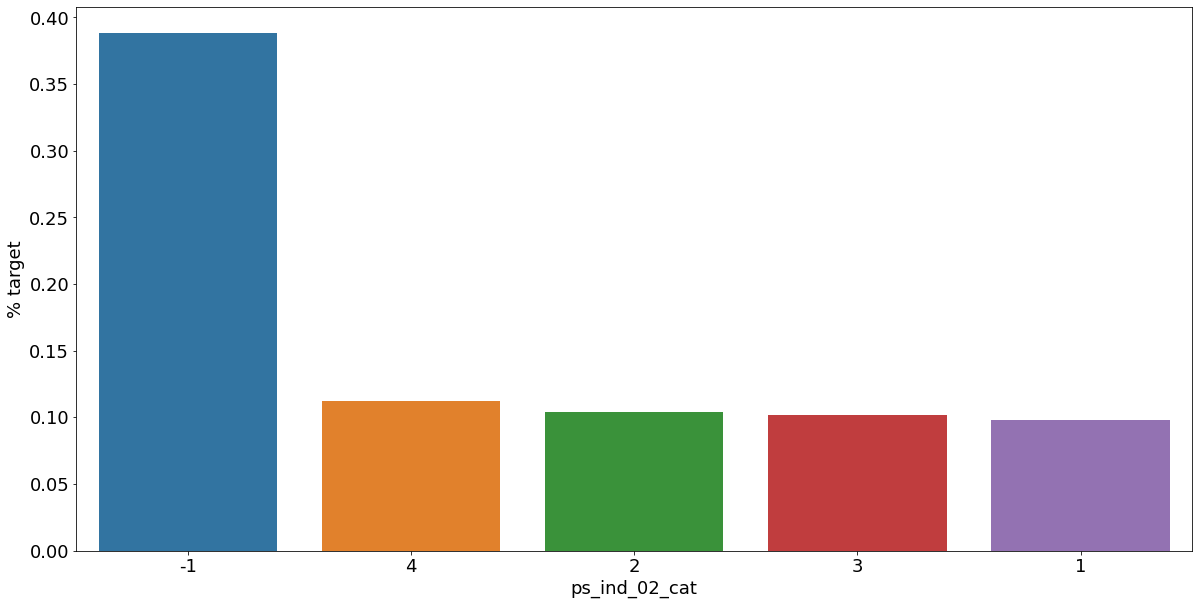

<Figure size 432x288 with 0 Axes>

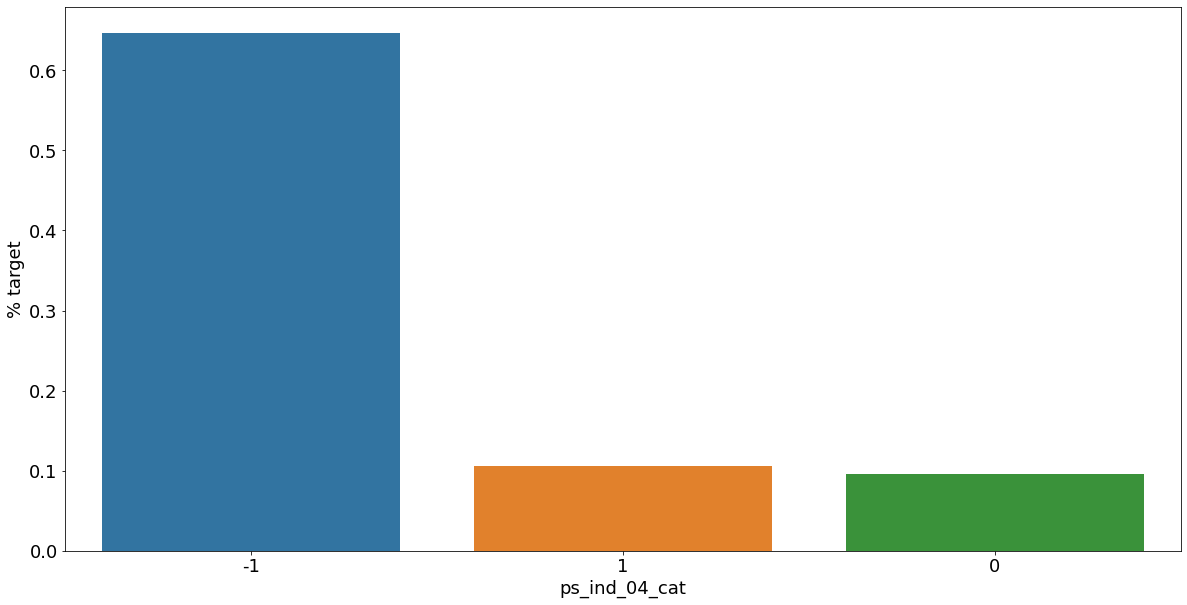

<Figure size 432x288 with 0 Axes>

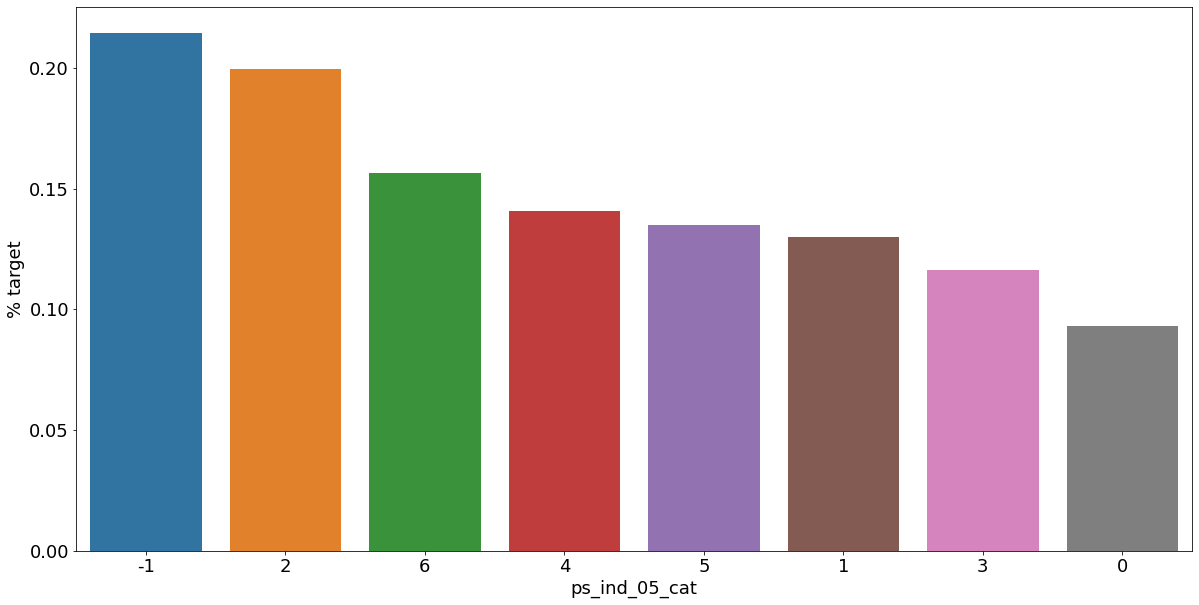

<Figure size 432x288 with 0 Axes>

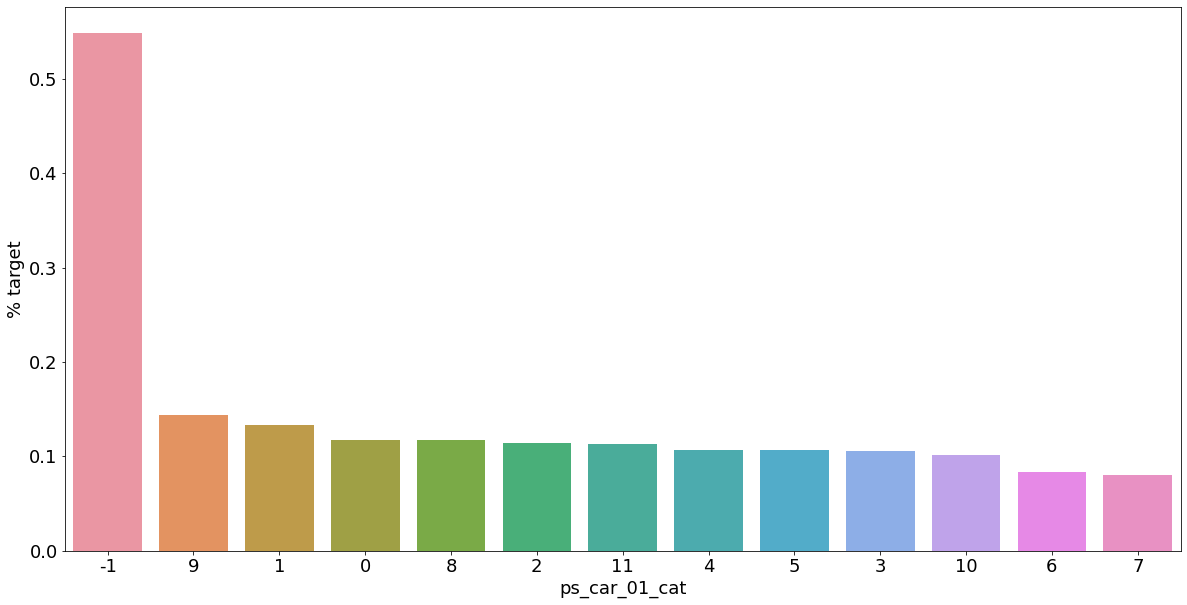

<Figure size 432x288 with 0 Axes>

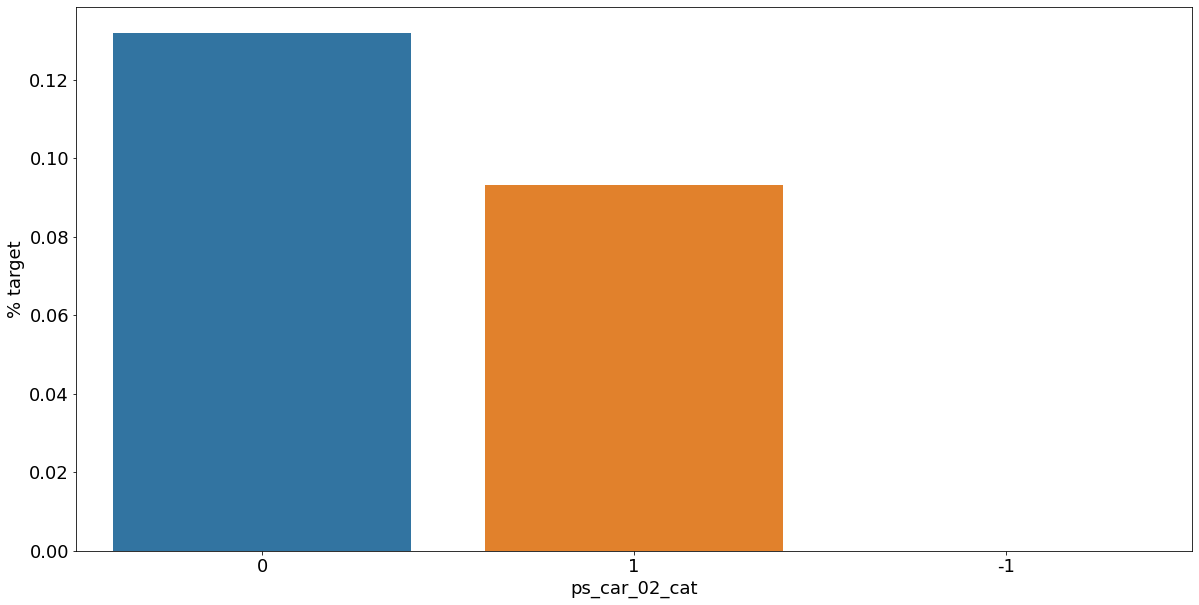

<Figure size 432x288 with 0 Axes>

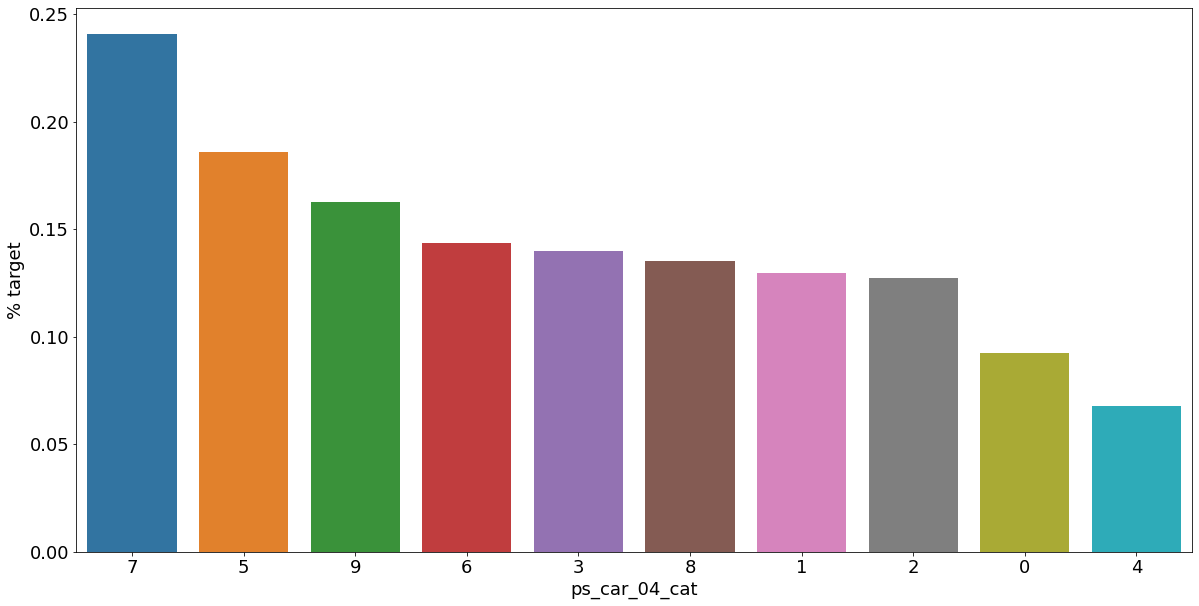

<Figure size 432x288 with 0 Axes>

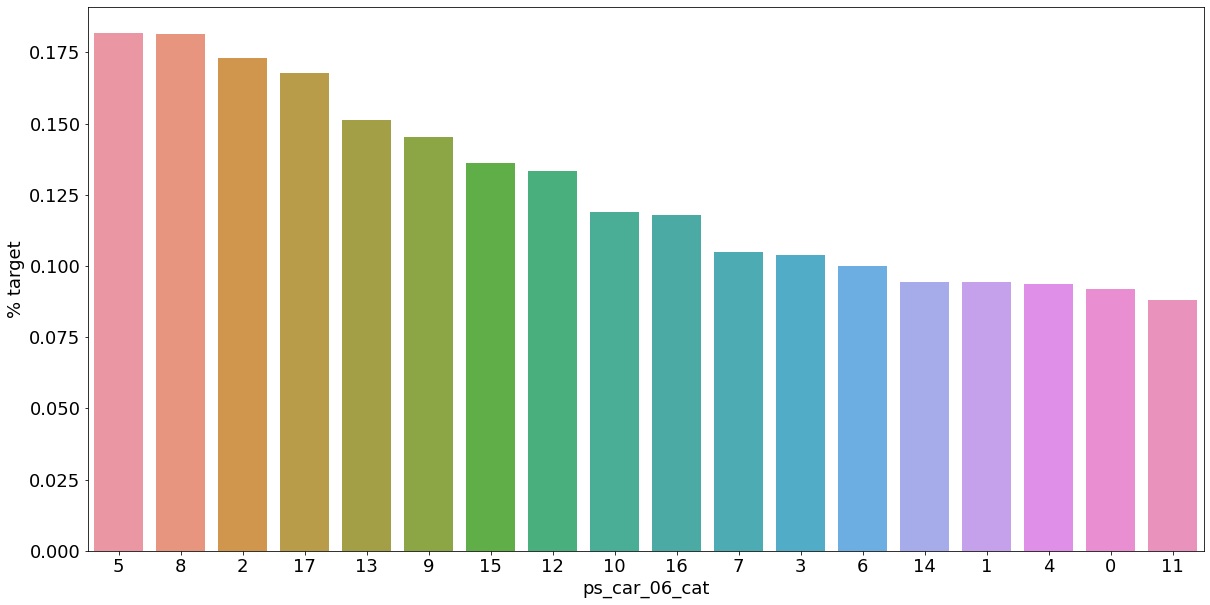

<Figure size 432x288 with 0 Axes>

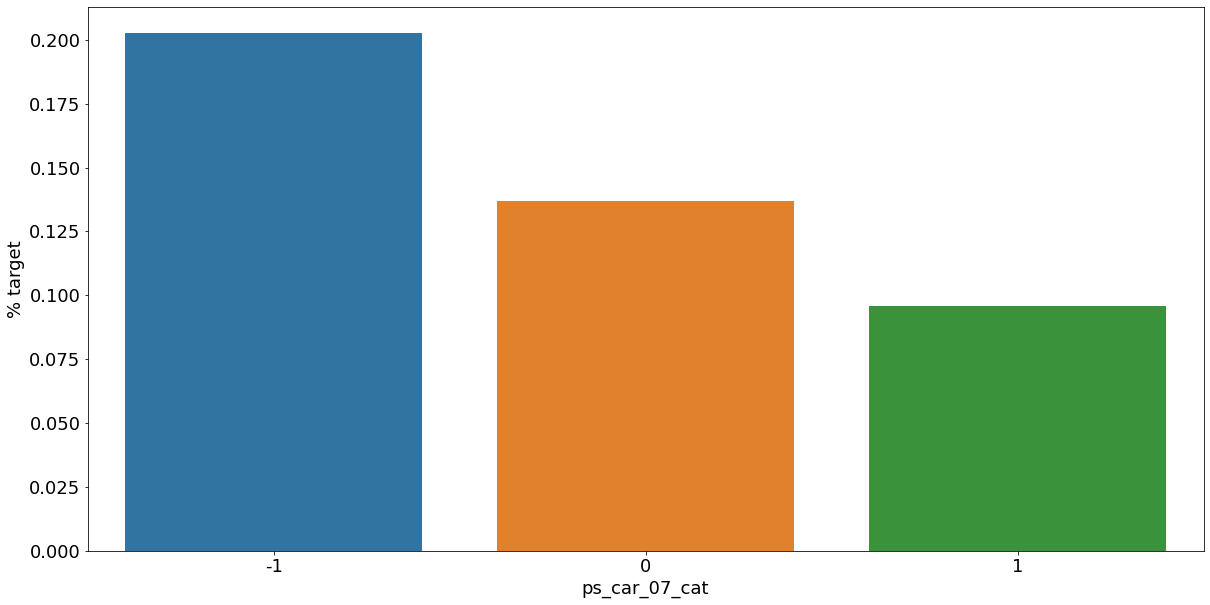

<Figure size 432x288 with 0 Axes>

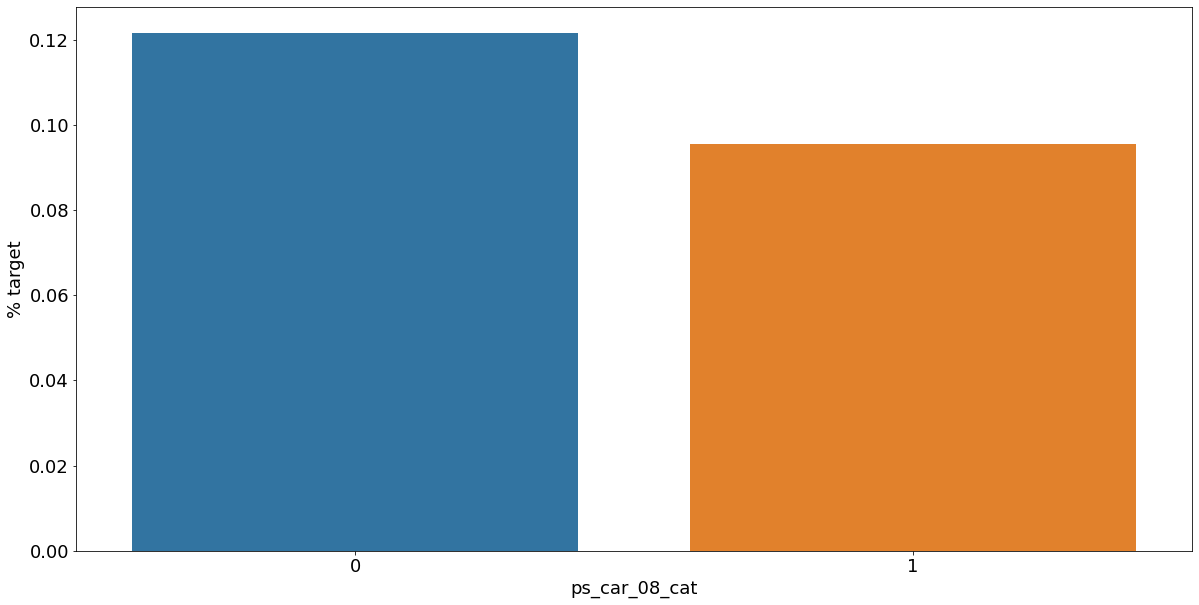

<Figure size 432x288 with 0 Axes>

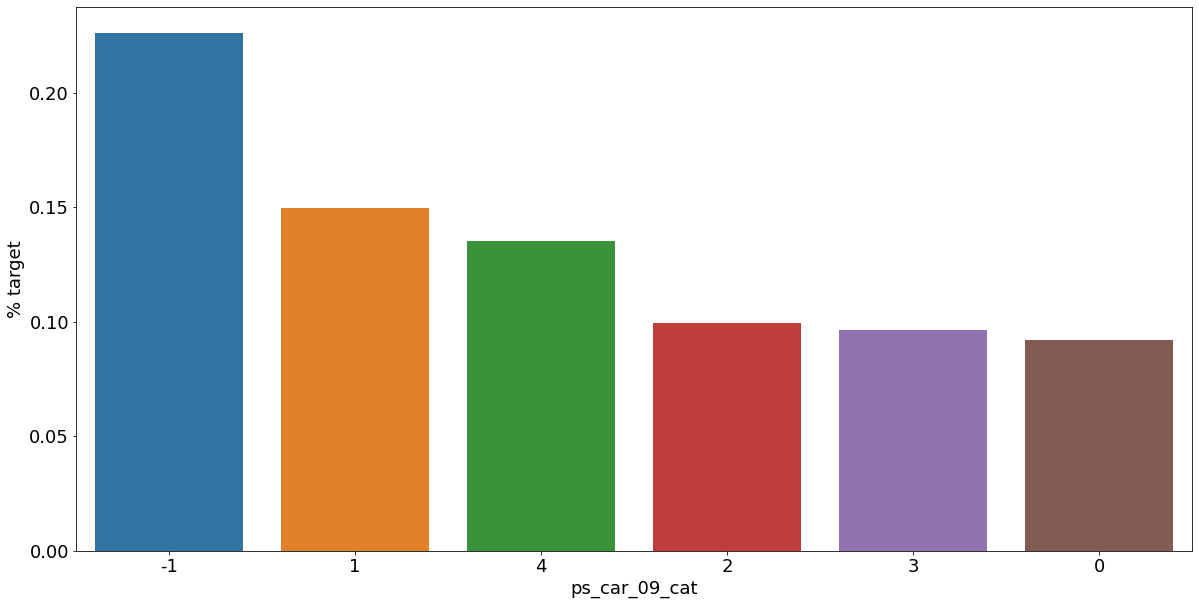

<Figure size 432x288 with 0 Axes>

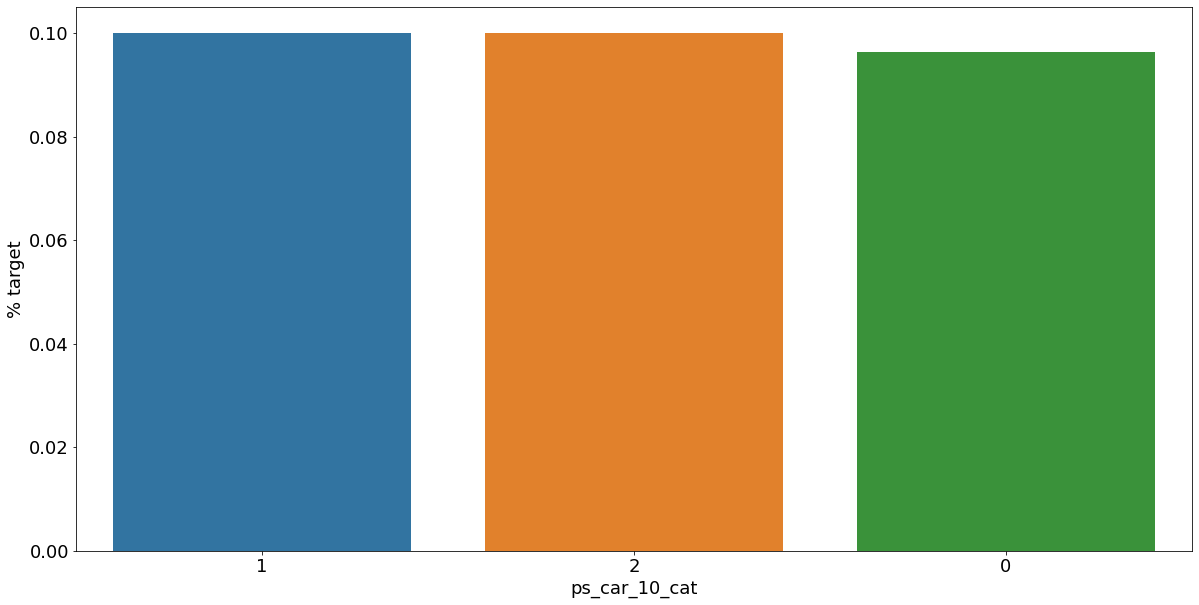

In [36]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

막대 그래프들을 통해 결측값이 있는 variables들을 확인할 수 있습니다. 앞서 결측값들을 치환했는데, categorical variables들은 따로 치환을 하지 않았습니다. 최빈값으로 대체하는 것보다 분리된 category value로서 결측값을 보는 것이 더 좋은 방법일 수 있습니다.

결측값을 가지고 있는 Customer들이 다른 Value들에 비하여 훨씬 높은 target 평균을 가지고 있기 때문입니다

### Interval variables

interval variables의 상관관계를 확인하고자 합니다. Heatmap은 Variables 간의 상관관계를 확인하는데 매우 효율적입니다. 하기 코드는 an example by Michael Waskom에 기반하고 있습니다.

* [seaborn : an example by Michael Waskom](http://seaborn.pydata.org/examples/many_pairwise_correlations.html)

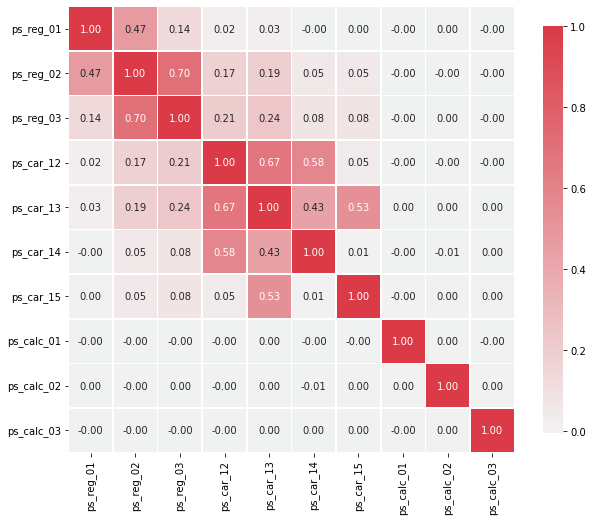

In [37]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

강한 상관관계를 가지고 있는 Variables들은 다음과 같습니다. :

* ps_reg_02 and ps_reg_03 (0.7)
* ps_car_12 and ps_car13 (0.67)
* ps_car_12 and ps_car14 (0.58)
* ps_car_13 and ps_car15 (0.67)

Seaborn의 pair plot을 사용하면 variables들의 (선형) 관계를 손쉽게 시각화할 수 있습니다. 하지만 히트맵이 상관관계가 있는 variables들의 관계들을 시각화해주고 있기 때문에, 우리는 높은 상관관계를 보이는 variables들을 분리해서 보고자 합니다.

프로세스의 속도를 높이기 위하여 train 데이터의 sample을 사용합니다

In [38]:
s = train.sample(frac=0.1)
s

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_car_11_cat_te
198377,213405,1,2,2,5,1,0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.7,0.1,0.561805,4,1,0,0,1,1,0,1,1,0.316070,0.622445,0.374433,2.236068,0.2,0.0,0.4,5,3,8,4,6,1,4,6,0,3,4,0,1,1,1,1,0,0.069850
47808,705137,0,0,1,4,0,0,1,0,0,0,0,0,0,0,0,3,0,0,1,0.7,0.4,0.770146,10,1,0,0,1,1,0,1,1,0.399875,0.646078,0.381707,2.000000,0.1,0.7,0.6,1,1,6,5,8,2,10,6,0,3,5,0,1,1,0,1,0,0.073066
179822,986573,0,3,1,6,1,6,0,0,1,0,0,0,0,0,0,6,1,0,0,0.6,0.8,1.188749,11,1,0,6,1,1,2,1,3,0.400000,0.943716,0.356090,3.464102,0.5,0.9,0.0,2,1,8,1,12,3,9,6,0,3,5,0,0,0,1,0,1,0.120577
162813,749367,0,5,1,8,0,0,0,1,0,0,0,0,0,0,0,10,0,0,0,0.6,0.2,0.657172,7,1,0,0,1,1,2,1,3,0.400000,0.938821,0.320000,3.464102,0.2,0.8,0.6,2,2,7,3,9,2,12,7,2,3,11,0,0,0,1,1,0,0.113712
81508,363271,0,1,1,2,0,0,1,0,0,0,0,0,0,0,0,9,0,1,0,0.6,0.7,0.813941,11,1,0,11,1,1,2,1,2,0.316228,0.677090,0.368782,3.464102,0.3,0.7,0.1,0,1,7,3,10,3,8,8,1,2,5,0,1,1,0,0,0,0.074786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11974,124342,0,2,1,2,0,0,0,1,0,0,0,0,0,0,0,10,0,0,0,0.7,0.6,0.649038,11,1,0,0,1,1,1,1,3,0.400000,0.778959,0.397492,3.000000,0.8,0.2,0.5,4,3,7,3,8,0,10,7,2,3,7,0,1,1,0,0,0,0.081599
144364,1482828,0,5,1,6,1,0,0,1,0,0,0,0,0,0,0,5,1,0,0,0.8,0.4,0.948354,10,1,0,4,1,1,0,1,2,0.316228,0.613316,0.380789,2.645751,0.5,0.6,0.3,0,4,6,5,8,3,3,4,2,5,8,0,0,1,1,1,1,0.120299
82840,762192,0,0,2,2,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.9,0.3,0.651441,7,1,0,11,1,1,2,1,2,0.316228,0.680802,0.368782,3.316625,0.8,0.8,0.1,2,3,7,3,8,4,8,7,1,3,7,0,0,1,0,0,0,0.074812
112517,414252,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.9,0.9,1.143460,4,1,0,1,1,1,0,1,1,0.316228,0.394932,0.354965,0.000000,0.9,0.9,0.0,0,2,7,1,6,3,6,5,1,3,5,0,1,0,0,1,0,0.085049


train 데이터에서 10%의 데이터를 샘플링합니다.

* train.shape ▶ (216940, 57)
* s.shape ▶ (21694, 57)

#### ps_reg_02 and ps_reg_03 (0.7)
회귀선이 보여주듯이, 두 variables들 간에는 선형 상관관계를 살펴볼 수 있습니다.

hue 파라미터를 통해 target=0과 target=1에 대한 회귀선이 동일함을 알 수 있습니다.

#### lmplot 확인

In [39]:
s.head(3)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_car_11_cat_te
198377,213405,1,2,2,5,1,0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.7,0.1,0.561805,4,1,0,0,1,1,0,1,1,0.316070,0.622445,0.374433,2.236068,0.2,0.0,0.4,5,3,8,4,6,1,4,6,0,3,4,0,1,1,1,1,0,0.069850
47808,705137,0,0,1,4,0,0,1,0,0,0,0,0,0,0,0,3,0,0,1,0.7,0.4,0.770146,10,1,0,0,1,1,0,1,1,0.399875,0.646078,0.381707,2.000000,0.1,0.7,0.6,1,1,6,5,8,2,10,6,0,3,5,0,1,1,0,1,0,0.073066
179822,986573,0,3,1,6,1,6,0,0,1,0,0,0,0,0,0,6,1,0,0,0.6,0.8,1.188749,11,1,0,6,1,1,2,1,3,0.400000,0.943716,0.356090,3.464102,0.5,0.9,0.0,2,1,8,1,12,3,9,6,0,3,5,0,0,0,1,0,1,0.120577


In [40]:
s[['ps_reg_02','ps_reg_03','target']]

,ps_reg_02,ps_reg_03,target
198377,0.1,0.561805,1
47808,0.4,0.770146,0
179822,0.8,1.188749,0
162813,0.2,0.657172,0
81508,0.7,0.813941,0
...,...,...,...
11974,0.6,0.649038,0
144364,0.4,0.948354,0
82840,0.3,0.651441,0
112517,0.9,1.143460,0


In [41]:
s.shape

(21694, 57)

In [42]:
s[['ps_reg_02','ps_reg_03','target']].describe()

,ps_reg_02,ps_reg_03,target
count,21694.000000,21694.000000,21694.000000
mean,0.445266,0.901502,0.098829
std,0.409225,0.316966,0.298439
min,0.000000,0.246221,0.000000
25%,0.200000,0.668954,0.000000
50%,0.300000,0.898861,0.000000
75%,0.600000,1.014889,0.000000
max,1.800000,2.947457,1.000000


In [43]:
s[['ps_reg_02','ps_reg_03','target']].corr()

,ps_reg_02,ps_reg_03,target
ps_reg_02,1.000000,0.699857,0.065356
ps_reg_03,0.699857,1.000000,0.054564
target,0.065356,0.054564,1.000000


* 평균, 표준편차, 상관계수, 회귀값이 동일한 데이터셋임을 확인
 * 데이터셋의 feature들의 분포가 각각 다르다면 회귀선을 비교할 때 lmplot을 통해 직관적으로 확인할 수 있다.
 * 보통은 feature들의 분포가 다 다를수 있기 때문에 직관적인 확인이 가능할 것으로 보인다.
* 그래프에 그림자가 생성되어야 하는데 생성되지 않음(데이터가 너무 많아서?)
 * 그림자처럼 표현된 곳은 데이터 분포에 대한 __신뢰구간__을 표시

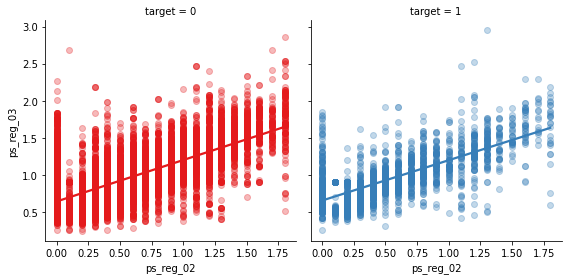

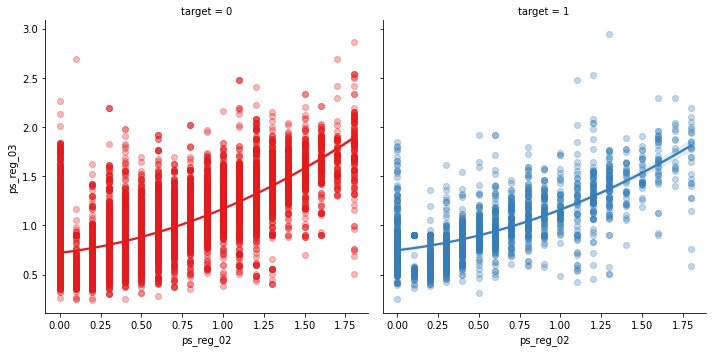

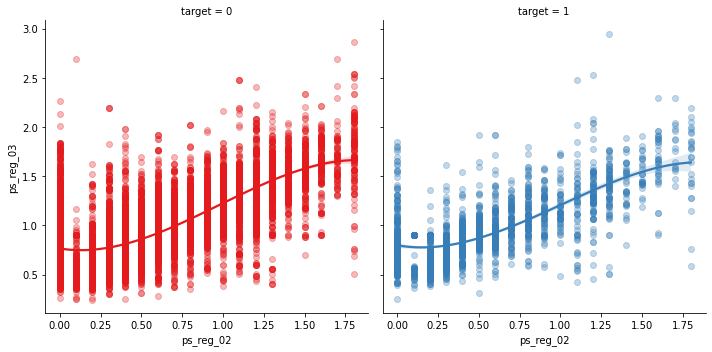

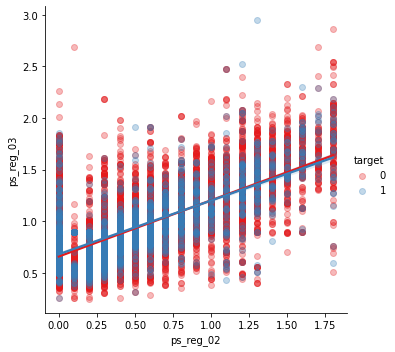

In [44]:
sns.lmplot(x='ps_reg_02',  
           y='ps_reg_03',  
           data=s,         # 데이터 
           hue='target',   # s['target']을 기준으로 다른 색상으로 그래프를 겹치게 그려놓음
           palette='Set1', # 그래프 색상 변경
           col='target',   # 분리
           order=1,        # 다항식 회귀 1, 2, 3 사용가능
           ci=None,        # 회귀 추정에 대한 신뢰구간 크기
           robust=True,    # outlier 제거용도
           scatter_kws={'alpha':0.3}, height=4) # scatter로 표현되어 있는 점의 투명도 조절

sns.lmplot(x='ps_reg_02',  
           y='ps_reg_03',  
           data=s,         
           hue='target',   
           palette='Set1', 
           col='target',   
           order=2,
           scatter_kws={'alpha':0.3}) 

sns.lmplot(x='ps_reg_02',  
           y='ps_reg_03',  
           data=s,         
           hue='target',   
           palette='Set1', 
           col='target',   
           order=3,
           scatter_kws={'alpha':0.3}) 

sns.lmplot(x='ps_reg_02', 
           y='ps_reg_03', 
           data=s, 
           hue='target', 
           palette='Set1',
           scatter_kws={'alpha':0.3})
plt.show()

#### ps_car_12 and ps_car_13 (0.67)

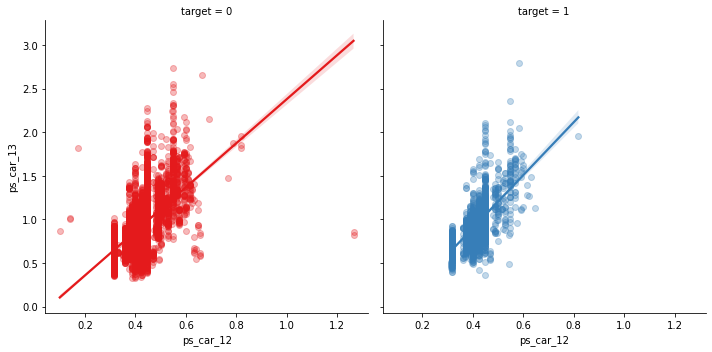

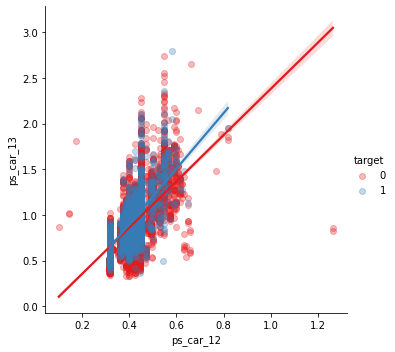

In [45]:
sns.lmplot(x='ps_car_12',
           y='ps_car_13', 
           data=s, 
           hue='target',
           col='target',
           palette='Set1', 
           scatter_kws={'alpha':0.3})

sns.lmplot(x='ps_car_12',
           y='ps_car_13', 
           data=s, 
           hue='target',
           palette='Set1', 
           scatter_kws={'alpha':0.3})
plt.show()

#### ps_car_12 and ps_car_14 (0.58)

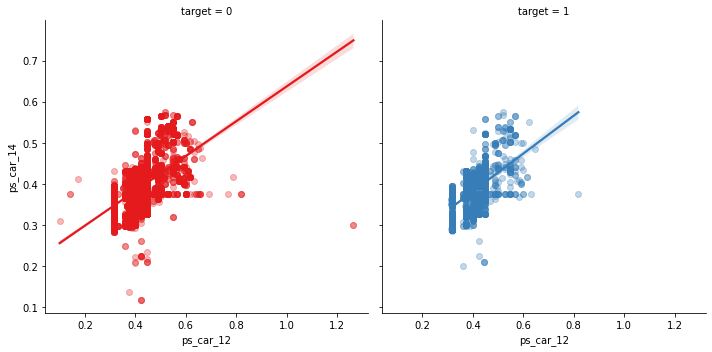

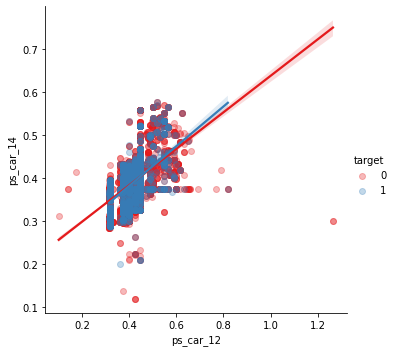

In [46]:
sns.lmplot(x='ps_car_12', 
           y='ps_car_14', 
           data=s, 
           hue='target', 
           col='target',
           palette='Set1', 
           scatter_kws={'alpha':0.3})

sns.lmplot(x='ps_car_12', 
           y='ps_car_14', 
           data=s, 
           hue='target', 
           palette='Set1',
           scatter_kws={'alpha':0.3})
plt.show()

#### ps_car_13 and ps_car_15 (0.67)

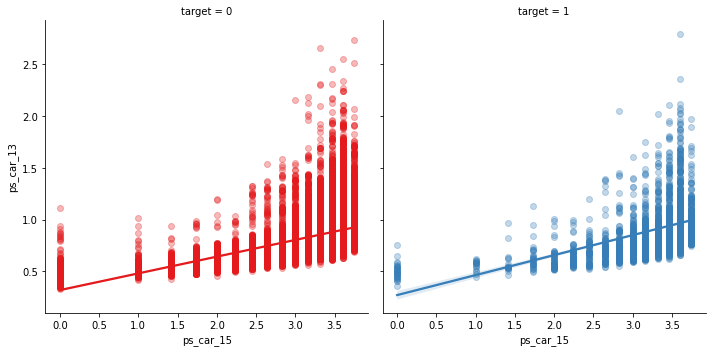

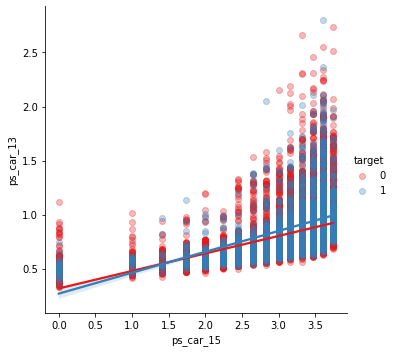

In [47]:
sns.lmplot(x='ps_car_15', 
           y='ps_car_13', 
           data=s, 
           hue='target',
           col='target',
           palette='Set1', 
           scatter_kws={'alpha':0.3})

sns.lmplot(x='ps_car_15', 
           y='ps_car_13', 
           data=s, 
           hue='target',
           palette='Set1', 
           scatter_kws={'alpha':0.3})
plt.show()

이제는 어떤 correlated variables를 유지할지 결정해야 합니다. 이를 위하여 우리는 Principal Component Analysis (PCA), 주성분 분석을 실시하여 variables의 dimensions를 줄일 수 있습니다. 하지만 correlated variables의 수가 적은만큼, 우리는 모델이 heavy-lifting을 하도록 해야합니다.

### Checking the correlations between ordinal variables

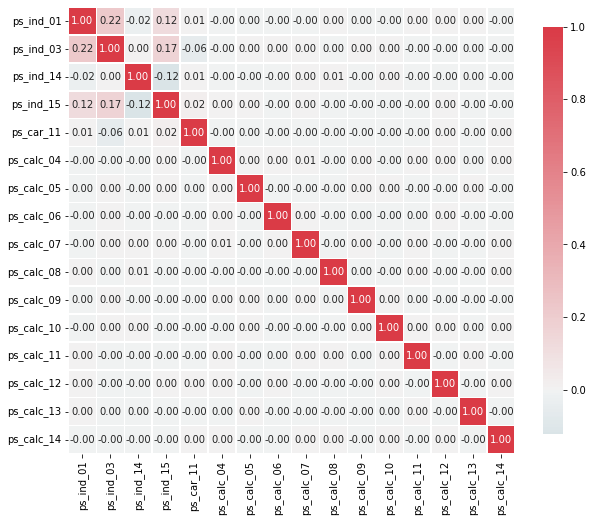

In [48]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

ordinal variables는 큰 상관관계를 가지고 있지 않은 것으로 보입니다. 반면에 target 값으로 그룹화할 때 분포가 어떻게 될지 확인할 수 있습니다.

## Feature engineering

### Creating dummy variables
categorical variables는 어떤 순서나 경중이 담겨있지 않습니다. 예를 들어서 카테고리 2는 카테고리 1보다 2배의 값을 가지고 있지 않습니다. 이 문제는 더미 데이터를 만들어줌으로써 해결할 수 있습니다. 첫 번째 dummy variable의 정보는 원래 variables의 범주에 대해 생성된 다른 dummy variable에서 파생될 수 있으므로 삭제해주도록 합니다.

In [49]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
train_ = train
print('Before dummification we have {} variables in train'.format(train.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 57 variables in train
After dummification we have 109 variables in train


dummy variables는 training 데이터 세트에 52개의 variables를 추가했습니다.

In [50]:
train.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_03', 'ps_ind_06_bin',
       'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin',
       'ps_ind_11_bin',
       ...
       'ps_car_07_cat_0', 'ps_car_07_cat_1', 'ps_car_08_cat_1',
       'ps_car_09_cat_0', 'ps_car_09_cat_1', 'ps_car_09_cat_2',
       'ps_car_09_cat_3', 'ps_car_09_cat_4', 'ps_car_10_cat_1',
       'ps_car_10_cat_2'],
      dtype='object', length=109)

### Creating interaction variables

In [58]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
print(poly)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)  # poly 처리가 되지 않은 기존의 열들을 삭제합니다.

# interactions와 train 데이터를 합쳐줍니다.
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

PolynomialFeatures(include_bias=False)
Before creating interactions we have 82 variables in train
After creating interactions we have 137 variables in train


In [62]:
interactions

,ps_reg_01^2,ps_reg_01 ps_reg_02,ps_reg_01 ps_reg_03,ps_reg_01 ps_car_12,ps_reg_01 ps_car_13,ps_reg_01 ps_car_14,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02^2,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03^2,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12^2,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13^2,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14^2,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2
0,0.36,0.36,0.502892,0.221269,0.324362,0.207413,1.200000,0.54,0.18,0.00,0.36,0.502892,0.221269,0.324362,0.207413,1.200000,0.54,0.18,0.00,0.702500,0.309095,0.453108,0.289739,1.676305,0.754337,0.251446,0.000000,0.136,0.199365,0.127483,0.737564,0.331904,0.110635,0.000000,0.292252,0.186880,1.081207,0.486543,0.162181,0.000000,0.1195,0.691375,0.311119,0.103706,0.000000,4.0,1.800000,0.600000,0.000000,0.81,0.27,0.00,0.09,0.00,0.00
1,0.81,0.54,0.655596,0.381838,0.344658,0.340933,0.000000,0.18,0.00,0.54,0.36,0.437064,0.254558,0.229772,0.227288,0.000000,0.12,0.00,0.36,0.530625,0.309051,0.278958,0.275943,0.000000,0.145688,0.000000,0.437064,0.180,0.162473,0.160717,0.000000,0.084853,0.000000,0.254558,0.146653,0.145068,0.000000,0.076591,0.000000,0.229772,0.1435,0.000000,0.075763,0.000000,0.227288,0.0,0.000000,0.000000,0.000000,0.04,0.00,0.12,0.00,0.00,0.36
2,0.81,0.54,0.782340,0.360000,0.732844,0.362131,2.984962,0.27,0.81,0.09,0.36,0.521560,0.240000,0.488563,0.241421,1.989975,0.18,0.54,0.06,0.755625,0.347707,0.707819,0.349765,2.883032,0.260780,0.782340,0.086927,0.160,0.325708,0.160947,1.326650,0.120000,0.360000,0.040000,0.663037,0.327637,2.700631,0.244281,0.732844,0.081427,0.1619,1.334504,0.120710,0.362131,0.040237,11.0,0.994987,2.984962,0.331662,0.09,0.27,0.03,0.81,0.09,0.01
3,0.36,0.90,1.023523,0.240000,0.503032,0.227051,2.163331,0.48,0.24,0.06,2.25,2.558808,0.600000,1.257580,0.567627,5.408327,1.20,0.60,0.15,2.910000,0.682349,1.430181,0.645532,6.150610,1.364698,0.682349,0.170587,0.160,0.335355,0.151367,1.442221,0.320000,0.160000,0.040000,0.702893,0.317260,3.022847,0.670710,0.335355,0.083839,0.1432,1.364405,0.302734,0.151367,0.037842,13.0,2.884441,1.442221,0.360555,0.64,0.32,0.08,0.16,0.04,0.01
4,0.64,0.64,0.869253,0.320000,0.724622,0.307870,2.884441,0.48,0.40,0.72,0.64,0.869253,0.320000,0.724622,0.307870,2.884441,0.48,0.40,0.72,1.180625,0.434626,0.984186,0.418151,3.917668,0.651939,0.543283,0.977909,0.160,0.362311,0.153935,1.442221,0.240000,0.200000,0.360000,0.820432,0.348577,3.265825,0.543466,0.452888,0.815199,0.1481,1.387552,0.230903,0.192419,0.346354,13.0,2.163331,1.802776,3.244996,0.36,0.30,0.54,0.25,0.45,0.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216935,0.36,0.24,0.922591,0.254558,0.761467,0.230825,1.897367,0.30,0.06,0.30,0.16,0.615061,0.169706,0.507645,0.153883,1.264911,0.20,0.04,0.20,2.364375,0.652371,1.951452,0.591547,4.862484,0.768826,0.153765,0.768826,0.180,0.538438,0.163218,1.341641,0.212132,0.042426,0.212132,1.610644,0.488237,4.013282,0.634556,0.126911,0.634556,0.1480,1.216553,0.192354,0.038471,0.192354,10.0,1.581139,0.316228,1.581139,0.25,0.05,0.25,0.01,0.05,0.25
216936,0.09,0.12,0.269658,0.127279,0.227094,0.120000,0.600000,0.09,0.12,0.18,0.16,0.359544,0.169706,0.302791,0.160000,0.800000,0.12,0.16,0.24,0.807951,0.3

PolynomialFeatures는 다항차수 변환을 진행을 도와주는 클래스입니다. 상기 코드의 경우 degree를 2로 설정했으니 2차항 변수로 만들어주는 것입니다.

이를 통해 train 데이터에 interaction variables를 추가할 수 있습니다. get_feature_names 메소드 덕분에 열 이름을 할당할 수 있습니다.

## Feature selection

### Removing features with low or zero variance

개인적으로 작성자는 분류기의 알고리즘이 유지할 features를 선택하는 것을 선호한다고 합니다. 하지만 우리 스스로 할 수 있는 일도 있습니다. 분산이 0이거나 아주 적은 features들을 제거하는 것입니다.


이를 위해 사이킷런의 VarianceThreshold라는 메소드를 사용할 수 있습니다. 기본적으로 이 메소드는 분산 값이 0인 features들을 제거해줍니다.


하지만 저희는 이전 단계에서 이미 분산이 0인 features가 없음을 확인했기 때문에, 우리는 1% 미만의 분산이 있는 features들을 제거해주고자 합니다. 이를 통해 우리는 31개의 variables를 제거하게 됩니다.

In [52]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # function to toggle boolean array elements

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

28 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


만약 우리가 분산에 기반하여 선택을 진행한다면 많은 variables들을 잃게 될 것입니다. 하지만 우리는 많은 variables를 가지고 있지 않기 때문에, 분류기가 직접 선택하도록 합니다. variables가 더 많은 데이터 셋이라면 처리 시간을 줄여줄 수 있을 것입니다.

사이킷런은 [feature selecetion methods]를 제공합니다. 이 메소드 중 하나가 'SelectFromModel' 인데, 다른 분류기에서 최상의 feature를 선택하고 기능을 계속할 수 있도록 합니다. 아래를 통해 랜덤 포레스트를 어떻게 사용하는지 확인해보도록 합니다.

### Selecting feature with a Random Forest and SelectFromModel

우리는 랜덤 포레스트의 feature importances에 따라 feature 선택의 기준을 삼습니다. SelectFromModel을 통하여 유지할 variables의 숫자를 구체화할 수 있습니다. feature의 중요도에 대한 임곗값을 수동으로 설정할수 있지만, 우리는 단순히 50% 이상의 최적의 variables를 선택해보도록 합시다.

하기의 코드는 이곳에서 가져왔습니다. [GitHub repo of Sebastian Raschka](https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch04/ch04.ipynb).

In [53]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target'] # 이게 뭐죠? -> 정답

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train , y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_11_cat_te               0.021271
 2) ps_car_13                      0.017416
 3) ps_car_12 ps_car_13            0.017249
 4) ps_car_13^2                    0.017230
 5) ps_car_13 ps_car_14            0.017144
 6) ps_reg_03 ps_car_13            0.017128
 7) ps_car_13 ps_car_15            0.016819
 8) ps_reg_01 ps_car_13            0.016723
 9) ps_reg_03 ps_car_14            0.016245
10) ps_reg_03 ps_car_12            0.015549
11) ps_reg_03 ps_car_15            0.015144
12) ps_car_14 ps_car_15            0.014998
13) ps_car_13 ps_calc_03           0.014749
14) ps_car_13 ps_calc_01           0.014710
15) ps_reg_01 ps_reg_03            0.014665
16) ps_reg_02 ps_car_13            0.014664
17) ps_car_13 ps_calc_02           0.014658
18) ps_reg_01 ps_car_14            0.014397
19) ps_reg_03^2                    0.014246
20) ps_reg_03                      0.014235
21) ps_reg_03 ps_calc_03           0.013822
22) ps_reg_03 ps_calc_02           0.013785
23) ps_reg_03 ps_calc_01        

* np.argsort : 정렬되지 않은 array를 정렬해서 반환
 * https://codetorial.net/tips_and_examples/numpy_argsort.html
 * 위의 feature_importances가 아마 정렬되지 않아서 사용한 것으로 추측

In [54]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]

print('Number of feature after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 162
Number of feature after selection: 81


* [sklearn 공식홈페이지 SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)
* [SelectFromModel 예시 설명 블로그](https://blog.naver.com/PostView.nhn?blogId=bosongmoon&logNo=221807565642)

In [55]:
train = train[selected_vars + ['target']]

In [56]:
train.head(3)

,ps_ind_01,ps_ind_03,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_car_11_cat_te,ps_reg_01^2,ps_reg_01 ps_reg_02,ps_reg_01 ps_reg_03,ps_reg_01 ps_car_12,ps_reg_01 ps_car_13,ps_reg_01 ps_car_14,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02^2,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03^2,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12^2,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13^2,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14^2,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2,target
0,1,1,11,0.6,0.6,0.838153,1,0.368782,0.540603,0.345688,2.000000,0.9,0.3,0.0,3,0,7,3,8,4,8,1,0,4,6,0.093657,0.36,0.36,0.502892,0.221269,0.324362,0.207413,1.200000,0.54,0.18,0.00,0.36,0.502892,0.221269,0.324362,0.207413,1.200000,0.54,0.18,0.00,0.702500,0.309095,0.453108,0.289739,1.676305,0.754337,0.251446,0.000000,0.136,0.199365,0.127483,0.737564,0.331904,0.110635,0.000000,0.292252,0.186880,1.081207,0.486543,0.162181,0.000000,0.1195,0.691375,0.311119,0.103706,0.000000,4.0,1.800000,0.600000,0.000000,0.81,0.27,0.00,0.09,0.00,0.00,0
1,5,7,5,0.9,0.6,0.728440,1,0.424264,0.382953,0.378814,0.000000,0.2,0.0,0.6,1,1,7,5,10,4,11,3,0,3,7,0.122173,0.81,0.54,0.655596,0.381838,0.344658,0.340933,0.000000,0.18,0.00,0.54,0.36,0.437064,0.254558,0.229772,0.227288,0.000000,0.12,0.00,0.36,0.530625,0.309051,0.278958,0.275943,0.000000,0.145688,0.000000,0.437064,0.180,0.162473,0.160717,0.000000,0.084853,0.000000,0.254558,0.146653,0.145068,0.000000,0.076591,0.000000,0.229772,0.1435,0.000000,0.075763,0.000000,0.227288,0.0,0.000000,0.000000,0.000000,0.04,0.00,0.12,0.00,0.00,0.36,0
2,4,3,4,0.9,0.6,0.869267,3,0.400000,0.814271,0.402368,3.316625,0.3,0.9,0.1,4,1,8,5,10,2,8,7,2,3,10,0.095514,0.81,0.54,0.782340,0.360000,0.732844,0.362131,2.984962,0.27,0.81,0.09,0.36,0.521560,0.240000,0.488563,0.241421,1.989975,0.18,0.54,0.06,0.755625,0.347707,0.707819,0.349765,2.883032,0.260780,0.782340,0.086927,0.160,0.325708,0.160947,1.326650,0.120000,0.360000,0.040000,0.663037,0.327637,2.700631,0.244281,0.732844,0.081427,0.1619,1.334504,0.120710,0.362131,0.040237,11.0,0.994987,2.984962,0.331662,0.09,0.27,0.03,0.81,0.09,0.01,0


## Feature scaling

이전에 언급했듯이, 우리는 train 데이터에 정규화를 진행할 수 있습니다. 몇몇 분류기에서는 더 나은 결과를 가져올 수 있을 것입니다.

In [57]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.45941104, -1.26665356,  1.05087653, ..., -0.72553616,
        -1.01071913, -1.06173767],
       [ 1.55538958,  0.95034274, -0.63847299, ..., -1.06120876,
        -1.01071913,  0.27907892],
       [ 1.05168943, -0.52765479, -0.92003125, ...,  1.95984463,
        -0.56215309, -1.02449277],
       ...,
       [-0.9631112 ,  0.58084336,  0.48776003, ..., -0.46445747,
         0.18545696,  0.27907892],
       [-0.9631112 , -0.89715418, -1.48314775, ..., -0.91202093,
        -0.41263108,  0.27907892],
       [-0.45941104, -1.26665356,  1.61399304, ...,  0.28148164,
        -0.11358706, -0.72653353]])

## Conclusion
필사 완료 다시 보기!

# 참고

* [[한글 번역 / 캐글 코리아 필사] Data Preparation & Exploration](https://www.kaggle.com/sihwanyoon/data-preparation-exploration)
* [선형회귀 위키피디아](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%ED%9A%8C%EA%B7%80)
* [공돌이의 수학노트 : 신뢰구간](https://angeloyeo.github.io/2021/01/05/confidence_interval.html)
* [scatter 위키피디아](https://ko.wikipedia.org/wiki/%EC%82%B0%EC%A0%90%EB%8F%84)
* [sns.lmplot 설명 블로그](https://stricky.tistory.com/124)
* [seaborn 공식홈페이지 : lmplot 설명](https://seaborn.pydata.org/generated/seaborn.lmplot.html)